In [2]:
import pandas as pd
import numpy as np

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json

from bs4 import BeautifulSoup
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics.pairwise import linear_kernel

# Loading CSV File and Cleaning

In [3]:
df = pd.read_csv("data/final/final_dataset_clean.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6767 entries, 0 to 6766
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   character_credits     6767 non-null   object
 1   character_died_in     6767 non-null   object
 2   concept_credits       6767 non-null   object
 3   cover_date            6767 non-null   object
 4   description           6669 non-null   object
 5   has_staff_review      6767 non-null   object
 6   id                    6767 non-null   int64 
 7   issue_number          6767 non-null   object
 8   location_credits      6767 non-null   object
 9   name                  6767 non-null   object
 10  object_credits        6767 non-null   object
 11  person_credits        6767 non-null   object
 12  story_arc_credits     6767 non-null   object
 13  team_credits          6767 non-null   object
 14  team_disbanded_in     6767 non-null   object
 15  volume                6767 non-null   

In [5]:
missing_values = df['description'].isnull().sum()
print(f"Missing Values: {missing_values}")

Missing Values: 98


**final_fillna** is just some final preprocessing. There cannot be null values when I go to vectorize. I found that my description lost some data between being exported and imported.

In [6]:
def final_fillna(df):
    df['description'] = df['description'].fillna('')
    df['combined_description'] = df['combined_description'].fillna('')
    lst = ['character_credits', 'character_died_in', 'concept_credits',
           'location_credits', 'object_credits', 'person_credits', 'story_arc_credits', 
           'team_credits', 'team_disbanded_in', 'volume']
final_fillna(df)

In [7]:
df.sample(3)

,character_credits,character_died_in,concept_credits,cover_date,description,has_staff_review,id,issue_number,location_credits,name,object_credits,person_credits,story_arc_credits,team_credits,team_disbanded_in,volume,combined_description
2916,"['Astra_Logue', 'Buer', 'First_of_the_Fallen',...",[],['Vertigo'],1995-08-24,"""Critical Mass"" part 1! As John Constantine wr...",False,41215,92,['Hell'],"Critical Mass, Part 1: Bait",[],"['Axel_Alonso', 'Clem_Robins', 'Lou_Stathis', ...",[],[],[],['Hellblazer'],"""Critical Mass"" part 1! As John Constantine wr..."
6172,"['Barbie', 'Dream_of_the_Endless_(Morpheus)', ...",[],"['Homosexuality', 'LGBTQ', 'Magic', 'Nudity', ...",1992-01-31,"In part 3 of ""A Game of You,"" Barbie's life is...",False,35234,34,['New_York_City'],"A Game of You, Part 3: Bad Moon Rising",[],"['Alisa_Kwitney', 'Colleen_Doran', 'Daniel_Voz...",[],['The_Three_Witches'],[],['The_Sandman'],"In part 3 of ""A Game of You,"" Barbie's life is..."
1529,"['Batman', 'Dick_Grayson']",[],['Silver_Age_of_Comics'],1969-09-28,See what happens when a civilian impersonates ...,False,112643,391,[],The Gal Most Likely to Be -- Batman's Widow!,[],"['Bob_Brown', 'Frank_Robbins', 'Gil_Kane', 'Jo...",[],[],[],['Detective_Comics'],See what happens when a civilian impersonates ...


In [8]:
def convert_to_list(list_str):
    return ast.literal_eval(list_str)

def apply_to_lst(df):
    lst = ['character_credits', 'character_died_in', 'concept_credits', 'location_credits', 'object_credits', 'person_credits',
      'story_arc_credits', 'team_credits', 'team_disbanded_in', 'volume']
    for col in lst:
        df[col] = df[col].apply(convert_to_list)

In [9]:
apply_to_lst(df)

In [10]:
df['character_credits'][20]

['Alura',
 'Blanque',
 'Cyborg_Superman',
 'General_Zod',
 'Jackee_Winters',
 'Jimmy_Olsen',
 'Jon_Kent',
 'Jonathan_Kent',
 'Jor-El',
 'Kelex',
 'Lana_Lang',
 'Lara_Lor-Van',
 'Lex_Luthor',
 'Lois_Lane',
 'Martha_Kent',
 'Metallo',
 'Mr._Mxyzptlk',
 'Perry_White',
 'Pete_Ross',
 'Ron_Troupe',
 'Steve_Lombard',
 'Supergirl',
 'Superman',
 'Zor-El']

Following the re-importing of the cleaned file, the lists are turned into strings so we need to convert them back to lists.

# EDA

## description

Description Length <= 20: 107


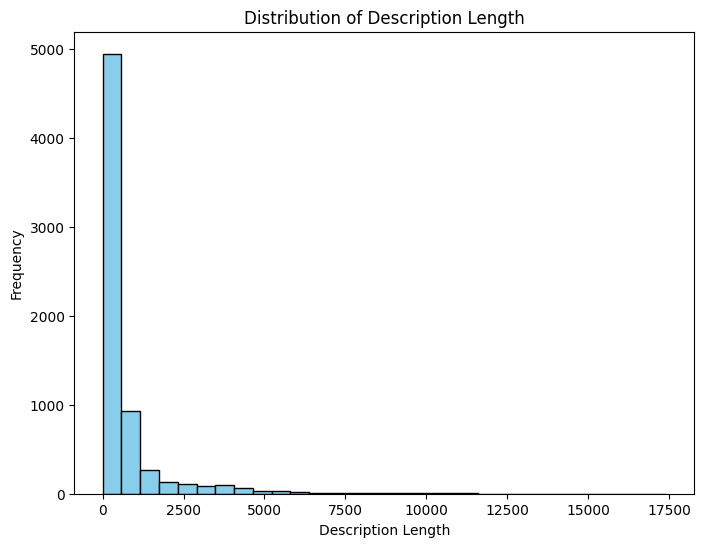

In [27]:
df['description_length'] = df['description'].apply(lambda x: len(str(x)))

num_zeros = (df['description_length'] <= 20).sum()
print(f'Description Length <= 20: {num_zeros}')

plt.figure(figsize=(8, 6))
plt.hist(df['description_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

Despite the super large first column, we were able to calculate that only 107 out of more than 6000 issues have descriptions that are less than 20 words or one sentence. Thus, most of the issues have enough of a description to work with when looking for similarities. 

## characters

count    6767.000000
mean        8.919610
std         6.648298
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        95.000000
Name: num_characters, dtype: float64
Number of entries with 0 characters: 322


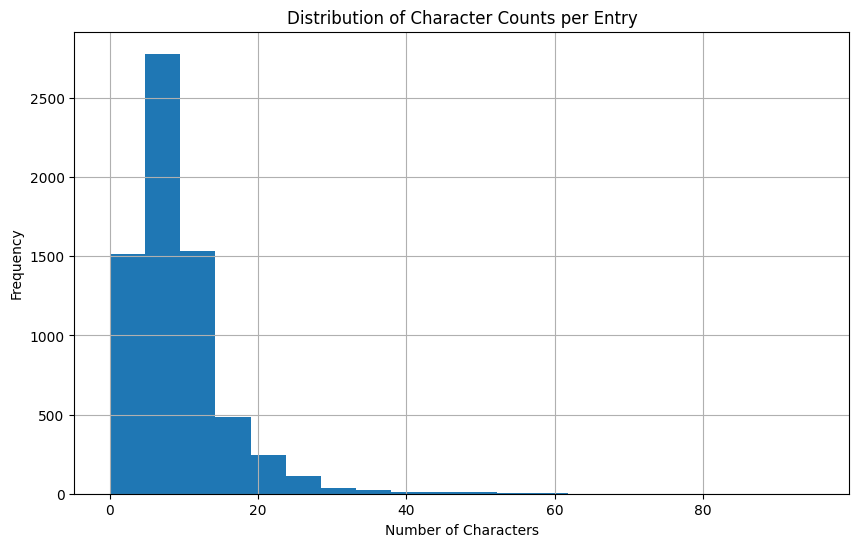

In [11]:
df['num_characters'] = df['character_credits'].apply(len)
print(df['num_characters'].describe())
num_zeros = (df['num_characters'] == 0).sum()
print(f'Number of entries with 0 characters: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_characters'].hist(bins=20)
plt.title('Distribution of Character Counts per Entry')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

<Figure size 1400x1000 with 0 Axes>

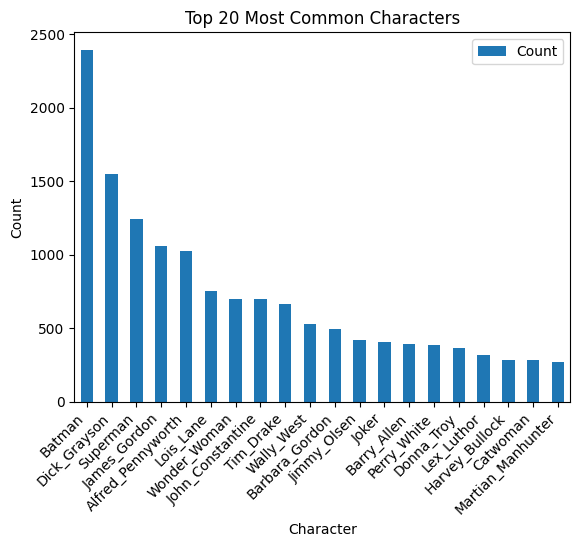

In [61]:
all_characters = [character for sublist in df['character_credits'] for character in sublist]
character_counts = Counter(all_characters)
character_counts_df = pd.DataFrame(character_counts.items(), columns=['Character', 'Count'])
character_counts_df = character_counts_df.sort_values(by='Count', ascending=False)
#print(character_counts_df.head(50))

plt.figure(figsize=(14, 10))
character_counts_df.head(20).set_index('Character').plot(kind='bar')
plt.title('Top 20 Most Common Characters')
plt.xlabel('Character')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## concepts

count    6767.000000
mean        2.455889
std         3.630238
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        43.000000
Name: num_concepts, dtype: float64
Number of entries with 0 concepts: 1923


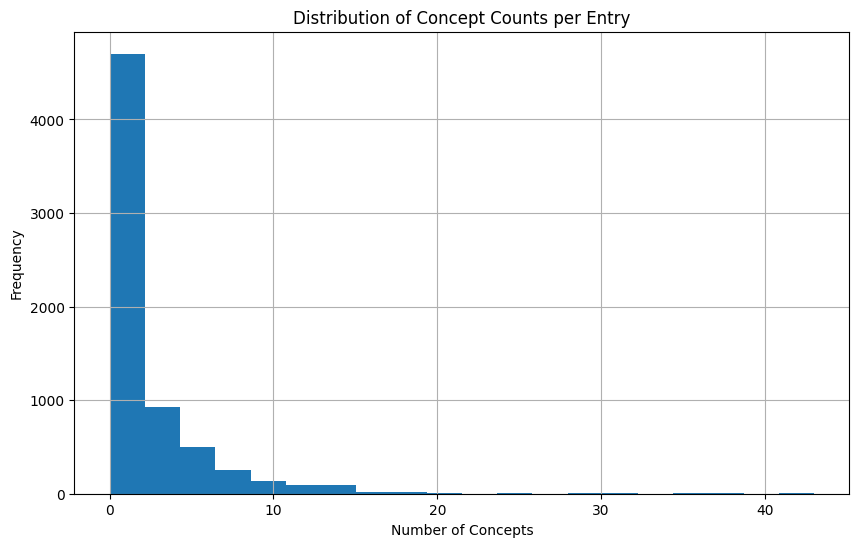

In [65]:
df['num_concepts'] = df['concept_credits'].apply(len)
print(df['num_concepts'].describe())
num_zeros = (df['num_concepts'] == 0).sum()
print(f'Number of entries with 0 concepts: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_concepts'].hist(bins=20)
plt.title('Distribution of Concept Counts per Entry')
plt.xlabel('Number of Concepts')
plt.ylabel('Frequency')
plt.show()

<Figure size 1400x1000 with 0 Axes>

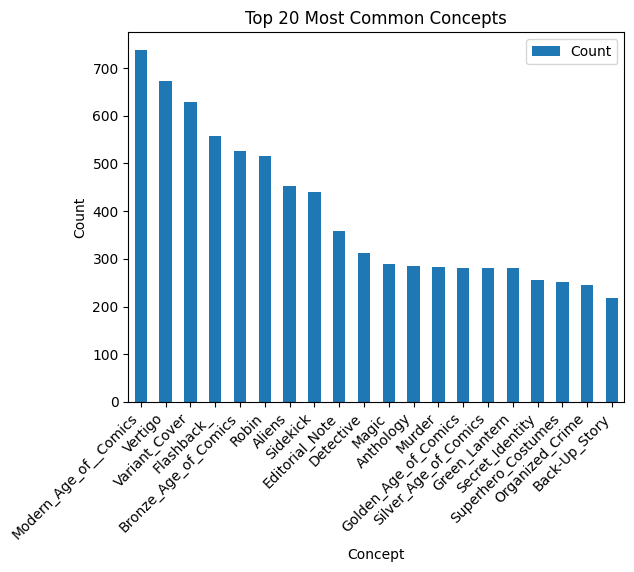

In [64]:
all_concepts = [concept for sublist in df['concept_credits'] for concept in sublist]
concept_counts = Counter(all_concepts)
concept_counts_df = pd.DataFrame(concept_counts.items(), columns=['Concept', 'Count'])
concept_counts_df = concept_counts_df.sort_values(by='Count', ascending=False)
#print(concept_counts_df.head(50))

plt.figure(figsize=(14, 10))
concept_counts_df.head(20).set_index('Concept').plot(kind='bar')
plt.title('Top 20 Most Common Concepts')
plt.xlabel('Concept')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## location

count    6767.000000
mean        2.155756
std         2.285615
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        45.000000
Name: num_locations, dtype: float64
Number of entries with 0 locations: 1527


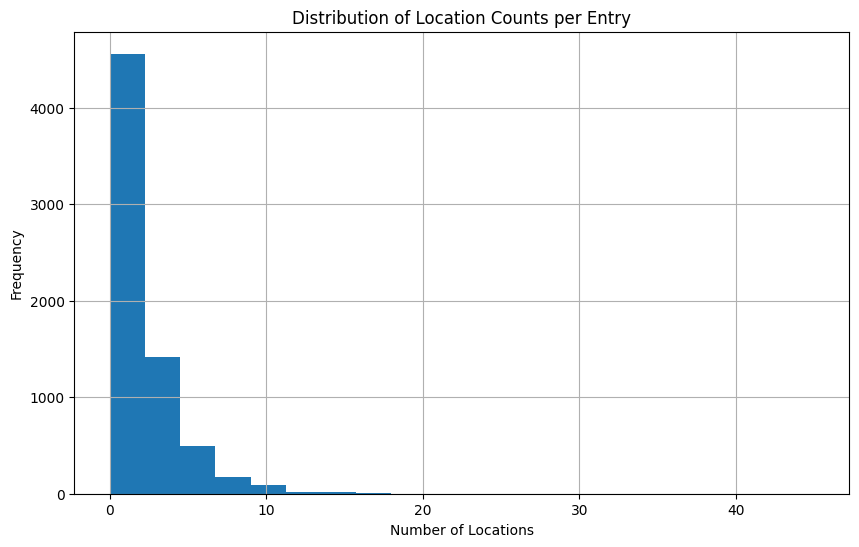

In [56]:
df['num_locations'] = df['location_credits'].apply(len)
print(df['num_locations'].describe())
num_zeros = (df['num_locations'] == 0).sum()
print(f'Number of entries with 0 locations: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_locations'].hist(bins=20)
plt.title('Distribution of Location Counts per Entry')
plt.xlabel('Number of Locations')
plt.ylabel('Frequency')
plt.show()

              Location  Count
33         Gotham_City   2050
69             Batcave    734
0           Metropolis    546
103        Wayne_Manor    533
41       New_York_City    431
20              London    297
71        Central_City    294
5                Space    253
120  GCPD_Headquarters    252
3         Daily_Planet    218


<Figure size 1200x800 with 0 Axes>

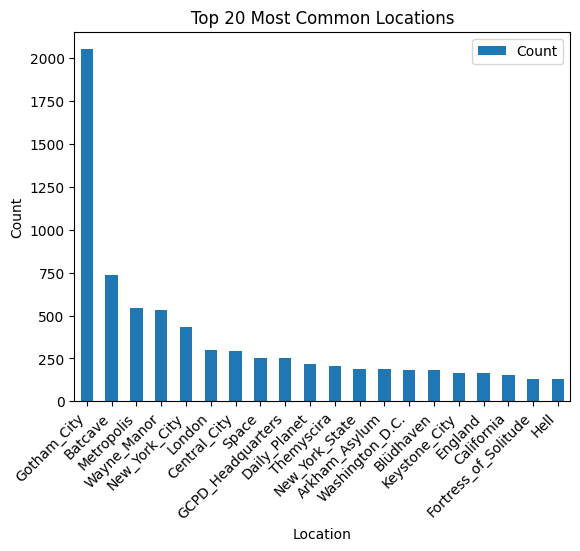

In [53]:
all_locations = [location for sublist in df['location_credits'] for location in sublist]
location_counts = Counter(all_locations)
location_counts_df = pd.DataFrame(location_counts.items(), columns=['Location', 'Count'])
location_counts_df = location_counts_df.sort_values(by='Count', ascending=False)
print(location_counts_df.head(10))

plt.figure(figsize=(12, 8))
location_counts_df.head(20).set_index('Location').plot(kind='bar')
plt.title('Top 20 Most Common Locations')
plt.xlabel('Location')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## objects

count    6767.000000
mean        0.790897
std         1.442110
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        10.000000
Name: num_objects, dtype: float64
Number of entries with 0 objects: 4500


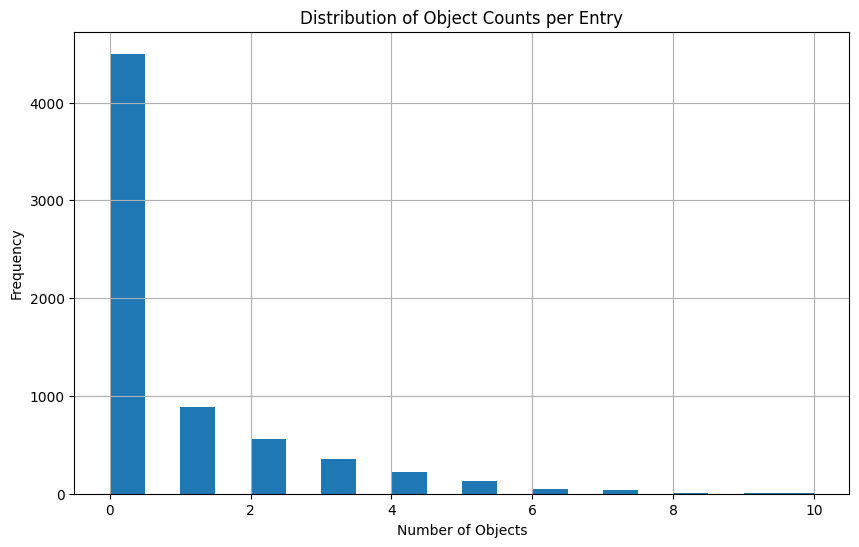

In [50]:
df['num_objects'] = df['object_credits'].apply(len)

print(df['num_objects'].describe())
num_zeros = (df['num_objects'] == 0).sum()
print(f'Number of entries with 0 objects: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_objects'].hist(bins=20)
plt.title('Distribution of Object Counts per Entry')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x800 with 0 Axes>

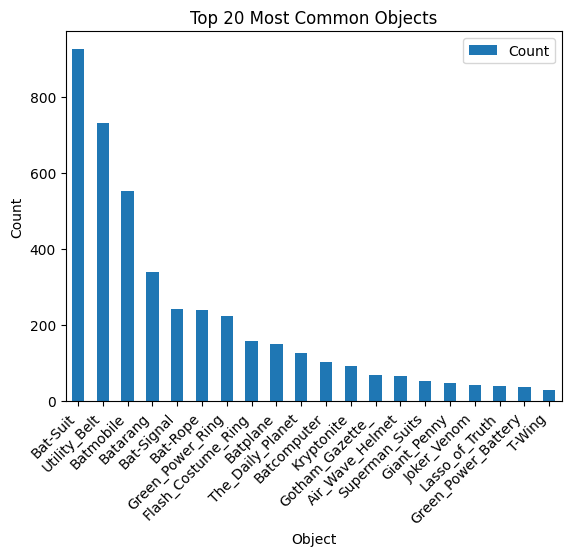

In [52]:
all_objects = [object for sublist in df['object_credits'] for object in sublist]
object_counts = Counter(all_objects)
object_counts_df = pd.DataFrame(object_counts.items(), columns=['Object', 'Count'])
object_counts_df = object_counts_df.sort_values(by='Count', ascending=False)
#print(object_counts_df.head(10))

plt.figure(figsize=(12, 8))
object_counts_df.head(20).set_index('Object').plot(kind='bar')
plt.title('Top 20 Most Common Objects')
plt.xlabel('Object')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## persons

count    6767.000000
mean        7.290084
std         3.779301
min         0.000000
25%         6.000000
50%         7.000000
75%         9.000000
max        65.000000
Name: num_persons, dtype: float64
Number of entries with 0 persons: 630


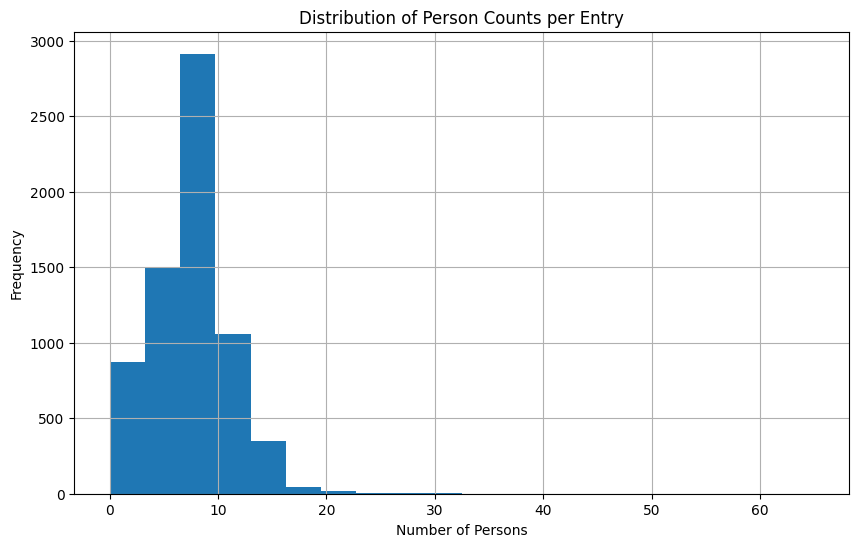

In [57]:
df['num_persons'] = df['person_credits'].apply(len)
print(df['num_persons'].describe())
num_zeros = (df['num_persons'] == 0).sum()
print(f'Number of entries with 0 persons: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_persons'].hist(bins=20)
plt.title('Distribution of Person Counts per Entry')
plt.xlabel('Number of Persons')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x800 with 0 Axes>

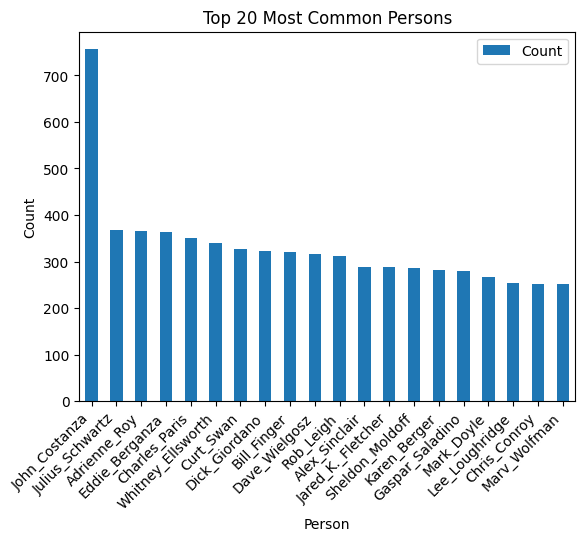

In [58]:
all_persons = [person for sublist in df['person_credits'] for person in sublist]
person_counts = Counter(all_persons)
person_counts_df = pd.DataFrame(person_counts.items(), columns=['Person', 'Count'])
person_counts_df = person_counts_df.sort_values(by='Count', ascending=False)
#print(person_counts_df.head(10))

plt.figure(figsize=(12, 8))
person_counts_df.head(20).set_index('Person').plot(kind='bar')
plt.title('Top 20 Most Common Persons')
plt.xlabel('Person')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## story arc

count    6767.000000
mean        0.063100
std         0.251527
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: num_story_arcs, dtype: float64
Number of entries with 0 story_arcs: 6354


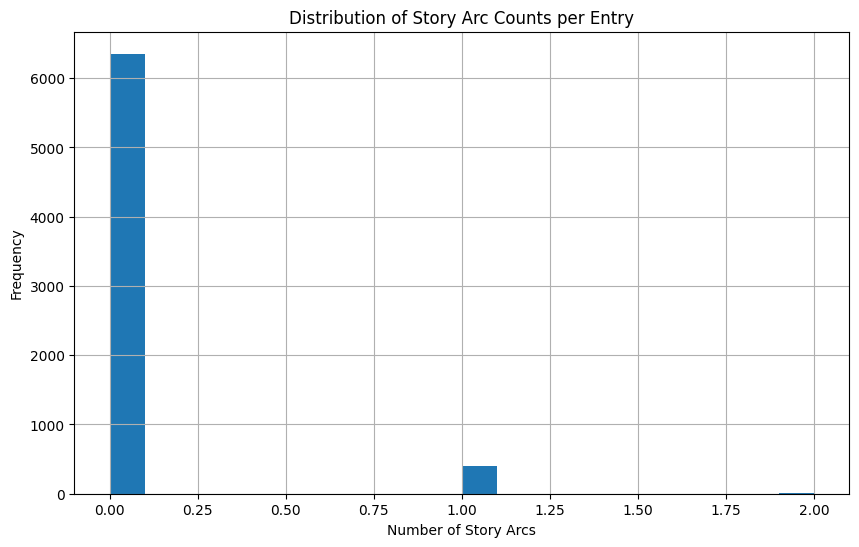

In [59]:
df['num_story_arcs'] = df['story_arc_credits'].apply(len)
print(df['num_story_arcs'].describe())
num_zeros = (df['num_story_arcs'] == 0).sum()
print(f'Number of entries with 0 story_arcs: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_story_arcs'].hist(bins=20)
plt.title('Distribution of Story Arc Counts per Entry')
plt.xlabel('Number of Story Arcs')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x800 with 0 Axes>

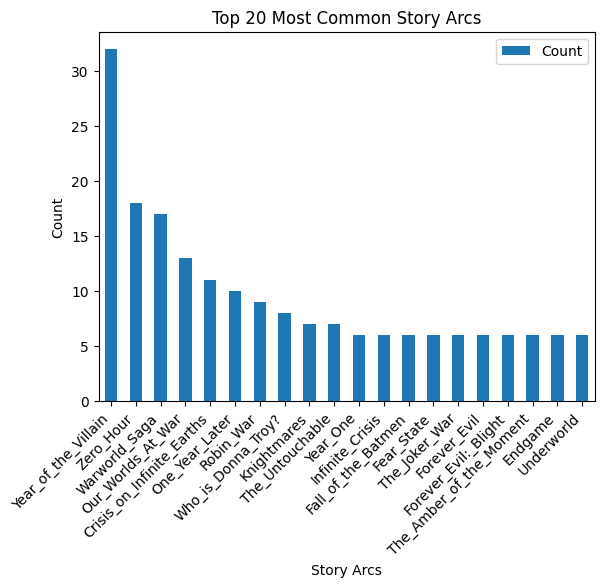

In [60]:
all_story_arcs = [story_arc for sublist in df['story_arc_credits'] for story_arc in sublist]
story_arc_counts = Counter(all_story_arcs)
story_arc_counts_df = pd.DataFrame(story_arc_counts.items(), columns=['Story Arc', 'Count'])
story_arc_counts_df = story_arc_counts_df.sort_values(by='Count', ascending=False)
#print(story_arc_counts_df.head(10))

plt.figure(figsize=(12, 8))
story_arc_counts_df.head(20).set_index('Story Arc').plot(kind='bar')
plt.title('Top 20 Most Common Story Arcs')
plt.xlabel('Story Arcs')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## teams

count    6767.000000
mean        1.357027
std         1.473955
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        12.000000
Name: num_teams, dtype: float64
Number of entries with 0 teams: 2300


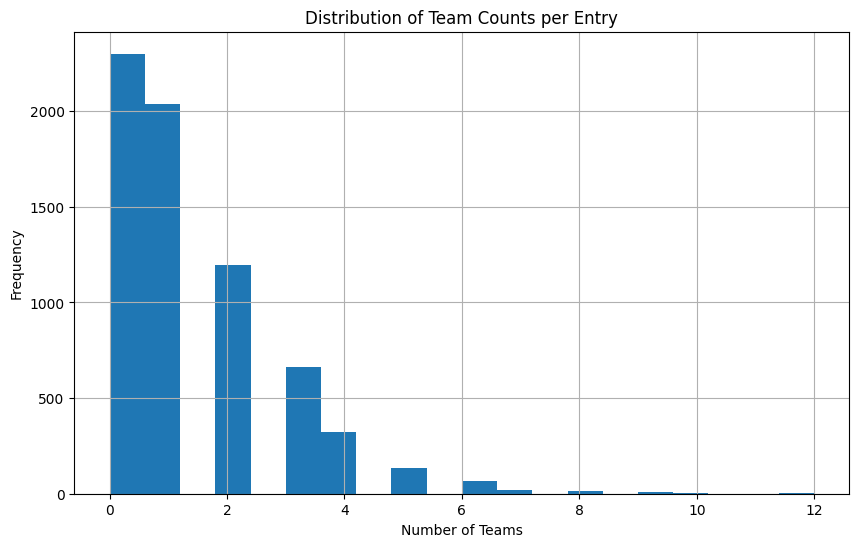

In [63]:
df['num_teams'] = df['team_credits'].apply(len)
print(df['num_teams'].describe())
num_zeros = (df['num_teams'] == 0).sum()
print(f'Number of entries with 0 teams: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_teams'].hist(bins=20)
plt.title('Distribution of Team Counts per Entry')
plt.xlabel('Number of Teams')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x800 with 0 Axes>

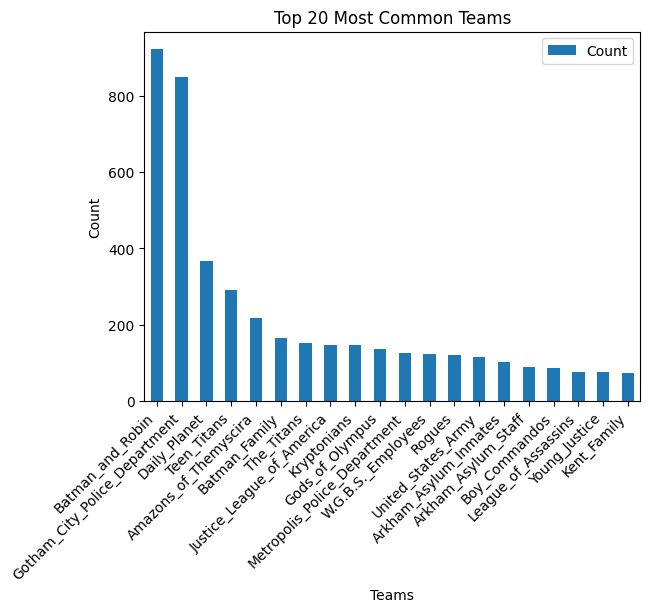

In [62]:
all_teams = [team for sublist in df['team_credits'] for team in sublist]
team_counts = Counter(all_teams)
team_counts_df = pd.DataFrame(team_counts.items(), columns=['Team', 'Count'])
team_counts_df = team_counts_df.sort_values(by='Count', ascending=False)
#print(team_counts_df.head(10))

plt.figure(figsize=(12, 8))
team_counts_df.head(20).set_index('Team').plot(kind='bar')
plt.title('Top 20 Most Common Teams')
plt.xlabel('Teams')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

## volume

count    6767.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: num_vol, dtype: float64
Number of entries with 0 volumes: 0


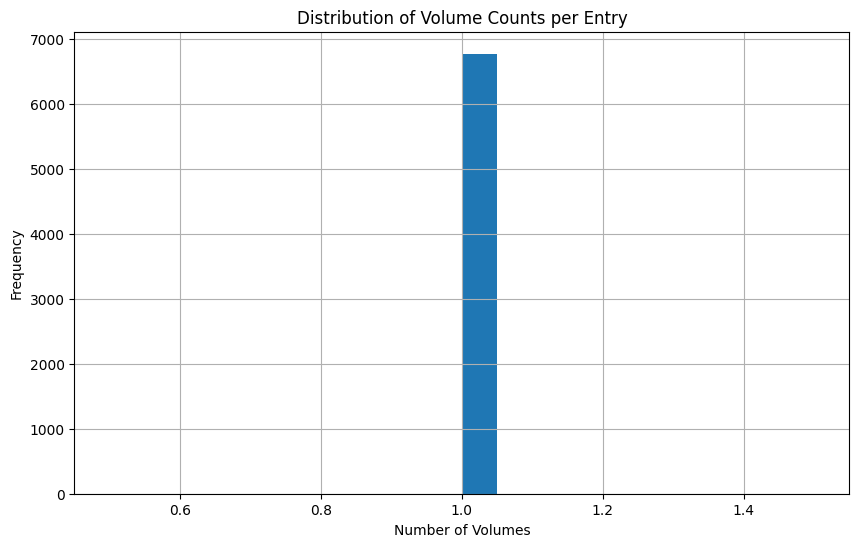

In [67]:
df['num_vol'] = df['volume'].apply(len)
print(df['num_vol'].describe())
num_zeros = (df['num_vol'] == 0).sum()
print(f'Number of entries with 0 volumes: {num_zeros}')

plt.figure(figsize=(10, 6))
df['num_vol'].hist(bins=20)
plt.title('Distribution of Volume Counts per Entry')
plt.xlabel('Number of Volumes')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x800 with 0 Axes>

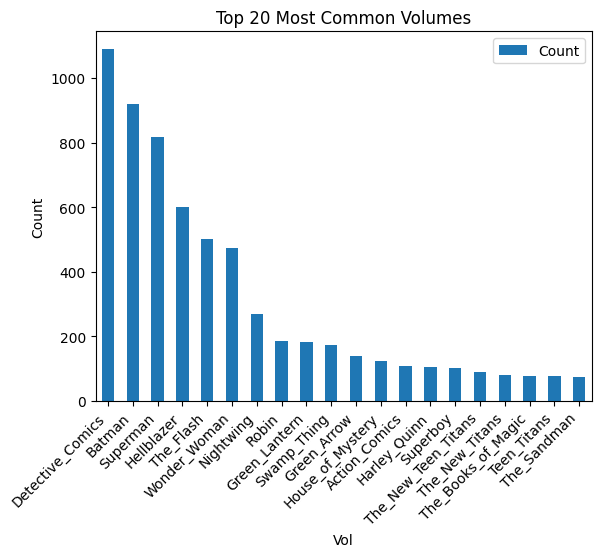

In [66]:
all_volumes = [vol for sublist in df['volume'] for vol in sublist]
volume_counts = Counter(all_volumes)
volume_counts_df = pd.DataFrame(volume_counts.items(), columns=['Vol', 'Count'])
volume_counts_df = volume_counts_df.sort_values(by='Count', ascending=False)
#print(volume_counts_df.head(10))

plt.figure(figsize=(12, 8))
volume_counts_df.head(20).set_index('Vol').plot(kind='bar')
plt.title('Top 20 Most Common Volumes')
plt.xlabel('Vol')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

# Conclusion

In [68]:
num_zeros = (df['description_length'] <= 20).sum()
print(f'Description Length <= 20: {num_zeros}')
num_zeros = (df['num_characters'] == 0).sum()
print(f'Number of entries with 0 characters: {num_zeros}')
num_zeros = (df['num_concepts'] == 0).sum()
print(f'Number of entries with 0 concepts: {num_zeros}')
num_zeros = (df['num_locations'] == 0).sum()
print(f'Number of entries with 0 locations: {num_zeros}')
num_zeros = (df['num_objects'] == 0).sum()
print(f'Number of entries with 0 objects: {num_zeros}')
num_zeros = (df['num_persons'] == 0).sum()
print(f'Number of entries with 0 persons: {num_zeros}')
num_zeros = (df['num_story_arcs'] == 0).sum()
print(f'Number of entries with 0 story arcs: {num_zeros}')
num_zeros = (df['num_teams'] == 0).sum()
print(f'Number of entries with 0 teams: {num_zeros}')
num_zeros = (df['num_vol'] == 0).sum()
print(f'Number of entries with 0 volume: {num_zeros}')

Description Length <= 20: 107
Number of entries with 0 characters: 322
Number of entries with 0 concepts: 1923
Number of entries with 0 locations: 1527
Number of entries with 0 objects: 4500
Number of entries with 0 persons: 630
Number of entries with 0 story arcs: 6354
Number of entries with 0 teams: 2300
Number of entries with 0 volume: 0


For each major feature, I looked at its destribution and top 20 entries. I found that among the data, the number of entries with 0 elements to be the most informative for my purposes.  <br>
There are only about 100 entries with less than a sentence in its description. This was especially important. It meant that I could use a recommendation system and NLP on description without much trouble. <br>
Volume and Characters are mostly all filled with information. <br>
So, are persons and locations. Then, concepts and teams. <br>
However,objects and story arcs are mostly empty. <br>

This means that I would probably not use story arcs in my final model. I would also lean towards volume and characters as my most important features. 